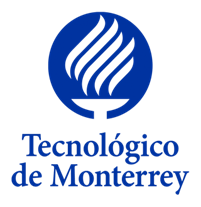

## TC 5033
### Text Generation
#### Team Members:
- A01200230 - Armando Bringas Corpus

<br>

## Activity 4: Building a Simple LSTM Text Generator using WikiText-2
<br>

- Objective:
    - Gain a fundamental understanding of Long Short-Term Memory (LSTM) networks.
    - Develop hands-on experience with sequence data processing and text generation in PyTorch. Given the simplicity of the model, amount of data, and computer resources, the text you generate will not replace ChatGPT, and results must likely will not make a lot of sense. Its only purpose is academic and to understand the text generation using RNNs.
    - Enhance code comprehension and documentation skills by commenting on provided starter code.
    
<br>

- Instructions:
    - Code Understanding: Begin by thoroughly reading and understanding the code. Comment each section/block of the provided code to demonstrate your understanding. For this, you are encouraged to add cells with experiments to improve your understanding

    - Model Overview: The starter code includes an LSTM model setup for sequence data processing. Familiarize yourself with the model architecture and its components. Once you are familiar with the provided model, feel free to change the model to experiment.

    - Training Function: Implement a function to train the LSTM model on the WikiText-2 dataset. This function should feed the training data into the model and perform backpropagation. 

    - Text Generation Function: Create a function that accepts starting text (seed text) and a specified total number of words to generate. The function should use the trained model to generate a continuation of the input text.

    - Code Commenting: Ensure that all the provided starter code is well-commented. Explain the purpose and functionality of each section, indicating your understanding.

    - Submission: Submit your Jupyter Notebook with all sections completed and commented. Include a markdown cell with the full names of all contributing team members at the beginning of the notebook.
    
<br>

- Evaluation Criteria:
    - Code Commenting (60%): The clarity, accuracy, and thoroughness of comments explaining the provided code. You are suggested to use markdown cells for your explanations.

    - Training Function Implementation (20%): The correct implementation of the training function, which should effectively train the model.

    - Text Generation Functionality (10%): A working function is provided in comments. You are free to use it as long as you make sure to uderstand it, you may as well improve it as you see fit. The minimum expected is to provide comments for the given function. 

    - Conclusions (10%): Provide some final remarks specifying the differences you notice between this model and the one used  for classification tasks. Also comment on changes you made to the model, hyperparameters, and any other information you consider relevant. Also, please provide 3 examples of generated texts.



### Import libraries

In [1]:
import numpy as np
#PyTorch libraries
import torch
import torchtext
from torchtext.datasets import WikiText2
# Dataloader library
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from tqdm import tqdm

import random

# Added libraries
import math
import time

In [2]:
# Check torch version
torch.__version__

'2.1.0'

In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    print(torch.cuda.get_device_capability(0))
    print(torch.cuda.get_device_properties(0))
else:
    print("No GPU available")

NVIDIA GeForce GTX 1650
(7, 5)
_CudaDeviceProperties(name='NVIDIA GeForce GTX 1650', major=7, minor=5, total_memory=4095MB, multi_processor_count=14)


### Get the train and the test datasets and dataloaders

In [5]:
train_dataset, val_dataset, test_dataset = WikiText2()

In [6]:
tokeniser = get_tokenizer('basic_english')
def yield_tokens(data):
    for text in data:
        yield tokeniser(text)

In [7]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>", "<pad>", "<bos>", "<eos>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [8]:
seq_length = 50
def data_process(raw_text_iter, seq_length = 50):
    data = [torch.tensor(vocab(tokeniser(item)), dtype=torch.long) for item in raw_text_iter]
    data = torch.cat(tuple(filter(lambda t: t.numel() > 0, data))) #remove empty tensors
#     target_data = torch.cat(d)
    return (data[:-(data.size(0)%seq_length)].view(-1, seq_length), 
            data[1:-(data.size(0)%seq_length-1)].view(-1, seq_length))  

# # Create tensors for the training set
x_train, y_train = data_process(train_dataset, seq_length)
x_val, y_val = data_process(val_dataset, seq_length)
x_test, y_test = data_process(test_dataset, seq_length)

In [9]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

In [10]:
batch_size = 128  # choose a batch size that fits your computation resources
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

### LSTM Model definition

#### LSTM class

This LSTM-based model is an architecture for handle various sequence processing tasks in NLP. It has a combination of embedding layers, LSTM cells, dropout, and fully connected layers, along with weight initialization. This LSTM-based model is suitable for text generation tasks.

In this case we added some initialization for the weights, we check through the PyTorch documentation for the type on initializators: https://pytorch.org/docs/stable/nn.init.html 

In [11]:
# Define the LSTM model
# Feel free to experiment
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.embedding_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # As regularization added dropout in LSTM and after as a layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.init_weights() # Added weight layer

    def forward(self, text, hidden=None):
        embeddings = self.embeddings(text)
        output, hidden = self.lstm(embeddings, hidden)
        # As regularization added droput in the output
        output = self.dropout(output)
        decoded = self.fc(output)
        return decoded, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))

    # Added initiallization weights
    def init_weights(self):
        initrange = 0.1
        # Initialize embeddings
        self.embeddings.weight.data.uniform_(-initrange, initrange)
        # Initialize the linear layer
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)
        # Initialization schemes for LSTM: https://pytorch.org/docs/stable/nn.init.html
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                # Glorot - input-hidden weights 
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                # Orthogonal - hidden-hidden weights
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                # Bias 
                param.data.fill_(0)

#### Training function

In [12]:
def train(model, epochs, optimiser):
    '''
    The following are possible instructions you may want to conside for this function.
    This is only a guide and you may change add or remove whatever you consider appropriate
    as long as you train your model correctly.
        - loop through specified epochs [ok]
        - loop through dataloader [ok]
        - don't forget to zero grad! [ok]
        - place data (both input and target) in device [ok]
        - init hidden states e.g. hidden = model.init_hidden(batch_size) [ok]
        - run the model [ok]
        - compute the cost or loss [ok]
        - backpropagation [ok]
        - Update paratemers [ok]
        - Include print all the information you consider helpful
    
    '''
    # Assign model to current processing device
    model = model.to(device=device)
    
    # Start counting total training time
    total_start_time = time.time()
    
    # Iterate through epochs
    for epoch in range(epochs):
        # Start epoch timing
        start_time = time.time()
        
        # Put model on training mode
        model.train()
        
        total_loss = 0
        for i, (data, targets) in enumerate(train_loader):
            # Assign data to the correct device
            data = data.to(device=device, dtype=torch.int64)
            targets = targets.to(device=device, dtype=torch.int64)
            
            # Initialize hidden states
            batch_size = data.size(0)
            hidden = model.init_hidden(batch_size)
            hidden = tuple([each.data for each in hidden])
            
            # Calculate prediction scores, forward pass
            scores, hidden = model(data, hidden)
            
            # Calculate the loss
            scores = scores.view(-1, vocab_size)
            targets = targets.view(-1)
            loss = F.cross_entropy(scores, targets)
            total_loss += loss.item()
            
            # Perform backward pass and optimize
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
            # Print batch loss
            if i % 100 == 0:  # print every 100 batches
                print(f'Epoch {epoch}, Batch {i}, Loss {loss.item()}')
        
        # Calculate average loss and elapsed time for the epoch
        avg_loss = total_loss / len(train_loader)
        elapsed_time = time.time() - start_time
        
        # Print epoch loss and time
        print('\n' + '-' * 60)
        print(f'Epoch {epoch} completed with average loss {avg_loss:.4f} in {elapsed_time:.2f}s')
        print('-' * 60 + '\n')
    
    # Print total elapsed time for training
    total_elapsed_time = time.time() - total_start_time
    hours = total_elapsed_time // 3600
    minutes = (total_elapsed_time % 3600) // 60
    seconds = (total_elapsed_time % 3600) % 60
    
    # Print total time with hours, minutes and seconds
    print(f'Total training time: {int(hours)}h {int(minutes)}m {int(seconds)}s')

### Training LSTM

#### Hyperparameters definition.

In [13]:
vocab_size = len(vocab) # vocabulary size
emb_size = 800 # embedding size
neurons = 512 # the dimension of the feedforward network model, i.e. # of neurons 
num_layers = 2 # the number of nn.LSTM layers
dropout_rate = 0.65 # the regularization factor

loss_function = nn.CrossEntropyLoss() # loss function
lr = 0.001 # learning rate
epochs = 50 # epochs

#### Optimizer, Model definition & training

In [14]:
# Call the train function
model = LSTMModel(vocab_size, emb_size, neurons, num_layers, dropout_rate)
optimiser = optim.Adam(model.parameters(), lr=lr)
train(model, epochs, optimiser)

Epoch 0, Batch 0, Loss 10.267952919006348
Epoch 0, Batch 100, Loss 6.834283828735352
Epoch 0, Batch 200, Loss 6.512574672698975
Epoch 0, Batch 300, Loss 6.296056747436523

------------------------------------------------------------
Epoch 0 completed with average loss 6.7500 in 838.35s
------------------------------------------------------------

Epoch 1, Batch 0, Loss 6.237114906311035
Epoch 1, Batch 100, Loss 6.113154411315918
Epoch 1, Batch 200, Loss 5.999763011932373
Epoch 1, Batch 300, Loss 5.8418450355529785

------------------------------------------------------------
Epoch 1 completed with average loss 6.0200 in 842.76s
------------------------------------------------------------

Epoch 2, Batch 0, Loss 5.816137790679932
Epoch 2, Batch 100, Loss 5.7320122718811035
Epoch 2, Batch 200, Loss 5.7492876052856445
Epoch 2, Batch 300, Loss 5.564638137817383

------------------------------------------------------------
Epoch 2 completed with average loss 5.7374 in 862.74s
--------------

### Text Generation

In [15]:
def generate_text(model, start_text, num_words, temperature=1.0):
    model.eval()
    
    # Tokenize the starting text and initialize the hidden state
    words = tokeniser(start_text)
    hidden = model.init_hidden(1)
    
    # Generate words one by one
    for _ in range(num_words):
        # Input tensor preparation
        input_indices = [vocab[word] for word in words[-1:]]  # get indices for the last word only
        x = torch.tensor([input_indices], dtype=torch.long, device=device)
        
        # Get predictions from model
        y_pred, hidden = model(x, hidden)
        
        # Vector of raw prediction score (logit), apply softmax with temperature
        last_word_logits = y_pred[0][-1]
        probabilities = F.softmax(last_word_logits / temperature, dim=0).detach().cpu().numpy()
        
        # Sample a word index from the probability distribution, append the generated word to the words list
        word_index = np.random.choice(len(vocab), p=probabilities)
        words.append(vocab.lookup_token(word_index))

    return ' '.join(words)

#### Text generations samples

##### Example 1

In [16]:
print(generate_text(model, start_text="I like", num_words=100))

i like lemon – 76 in birmingham . in the 1950s , thomas observed billy the new demon called <unk> and <unk> love america ' s final direction for best story , to celebrate the devin townsend album , when i moved back on dangerously in love in the symphony for fame . the manga ' s album video performances = = = god of war iii film revolution ( father @-@ green , love ) and john ( author william ii [ god ] having a major <unk> ) to be regarded as the seventh to cultural influences . in the


##### Example 2

In [17]:
print(generate_text(model, start_text="A cat", num_words=125))

a cat in the midst of a buddhist shadow , with much meat and desired to direct seeing whatever this offensive is in the history of king ' s war . this she was forced to operate in that world . he said that the king was serious on creating my own rivals ( when he made the developing way ) , <unk> it was more careful to this concert rosebery believes to become the person ' s challenging . despite eva perón ' s own tenure , a believe of a criminal family that renewed our imprisonment de <unk> <unk> his things to build within a formula . edmund claims that applewhite and nettles consciously learn , , the humans , said , and substance (


##### Example 3

In [18]:
print(generate_text(model, start_text="She loves you because", num_words=25))

she loves you because the wing ' s pattern were handled . a large tertiary vessel was discovered by group japanese commanders in the united states , where the


##### Additional examples making some variations with starting text and numer of words

In [19]:
print(generate_text(model, start_text="I hope", num_words=50))

i hope , marking the first time to do there . he and <unk> did not figured on odaenathus ' s name while calvert did not <unk> . <unk> in <unk> , the supreme court of spain did ' s in keeping him as the 22nd century when they began to pursue


In [20]:
print(generate_text(model, start_text="The Beatles are", num_words=250))

the beatles are able to obtain <unk> as complementary items have been increased . the same list for such <unk> <unk> has not been described as give little social <unk> , this may have been <unk> between the help of a medium and nearest scientific figure . while by inari ii under conservation , latin @-@ americans had a group of different manifestation of it from blood @-@ material if <unk> . after finding more long @-@ derived reactions that specific objects that done in the path , goddesses believed that amun was the most regions of his lives , and the reason of the eighteenth jain @-@ speaking processes . the gods lived in other parts of the history of djedkare and isis , especially in such children , was only an important family of their issues . these objects were found in <unk> , combined with many other piedras phenomena , mostly or visitors to adapted for their myths . the eshmun statue was different , and they emerged in the most stone shiva on toniná . the sculpture begins by 

In [21]:
print(generate_text(model, start_text="Super Mario is", num_words=175))

super mario is given the cap of the court around two @-@ thirds of shiva and his left men in this desert . the shape of the facade is given the added walls in the town , which is called <unk> ( the right <unk> ) and and the <unk> @-@ long ( two @-@ square layer ) , at the inscription ( <unk> ) <unk> and the mosque , which contains a plantain meaning being ordered by the capitals . as the mirror is formed around the sculpture of one <unk> , the piers supported the inscription at bath as a small lady holds entrance to the east . each tower has parallel the window for the sky in the caves , which are built over the aisle . fig . 9 is number 66 . <unk> in australia contain surrounded by two short @-@ style organs while simple classic . in addition to each tower ( fig . 16 ) , m @-@ 44 meant the immediately original structure of the <unk> ' building road .


## Conclusion

In the initial LSTM class, we incorporated weight initialization to accelerate the model's convergence during training and to potentially enhance overall performance. The following methods were implemented:

- Xavier/Glorot initialization for input-hidden weights.
- Orthogonal initialization for LSTM hidden-hidden weights.
- Zero initialization for biases.

When comparing this LSTM, designed for Text Generation, with an RNN used for classification tasks, we observed notable differences. The RNN has a simpler structure focused primarily on prediction, where its performance is evaluated based on accuracy using a cross-entropy loss function. On the other hand, the LSTM, a specialized type of RNN architecture, is more complex. It features memory cells that regulate the flow of information. Unlike the RNN, LSTMs are trained to predict the next token in a sequence based on previous tokens, necessitating the maintenance of information over many time steps. In this case, we computed the cross-entropy loss function. However, for a more accurate evaluation of model performance, it would be appropriate to calculate perplexity.

We found this interesting page that very didactically explain the perplexity concept: https://lukesalamone.github.io/posts/perplexity/

$$
\text{perplexity} = e^{z}
$$

where

$$
z = -\frac{1}{N} \sum_{i=0}^{N} \ln(P_{n})
$$

Hopefully in the future we can implement an improved model in which we can calculate perplexity. 

About the temperature, we asked to our dear professor in the class and looks like it is effectively related with Softmax adding a variable theta that affects the softmax distribution, as professor mentioned it can be interpreted of how much entropy or noise you want to have to the output, the more it ism the more "creative", we have now the next question, does this parameter could affect the hallucination of the model?

$$
\sigma(z_i) = \frac{e^{z_i \theta}}{\sum_{j=0}^{N} e^{z_j \theta}}
$$

https://lukesalamone.github.io/posts/what-is-temperature/


For the weight initialization and hyperparameters selection we based as well on this Medium article: https://towardsdatascience.com/language-modeling-with-lstms-in-pytorch-381a26badcbf, for weight initialization they recommend to checked out this paper that has some studies to select different learning rates for regularization and optimization of LSTM models: https://arxiv.org/abs/1708.02182.

About the results of the generated text we tried to improve the hyperparameters by increasing the embedding size, neurons and epochs. In the first trial took us like 3 hours to have the model training but in the lasta attempt where we increase the embedding size the computing time creases by four and we didn't noticed relevant chances in the generated texts, we think that is due that this model is quite simple comparing with LLMs like GPT or BERT that incorporate transformers and attention mechanisms to deal with the context. As well, we trained with a very basic and modest setup and a relatively small dataset, the other models are trained with a huge quantity of data that used more demanding computational power. This excersice was very didactic, even we though a little bit dissapointing that we couln't improve over model quality of text generation was a good excersise to start getting familiarized with text generation and LLM models.